In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch
import seaborn as sns
from scipy import stats
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorNeuropixelsProjectCache

#### Confirmation of finding:

We just want to confirm the finding of the correlation between # of sessions and the strategy index, and whether that is before hand-off or not.

__Conclusion__: strategy index is correlated with TOTAL number of sessions, not before hand-off.

In [2]:
drive_dir = "/Volumes/Brain2024"
cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(cache_dir=drive_dir, use_static_cache=True)
behavior_sessions = cache.get_behavior_session_table()

In [6]:
# subset sessions that match the ones we got the strategy index from:
subset_sessions = behavior_sessions[
    (behavior_sessions.session_type.str.contains('EPHYS')) & 
    (behavior_sessions.genotype == 'wt/wt')
]

- `epilogue` sessions are the before hand-off sessions in `TRAINING_5`:



Found out during my digging around [SDK repo](https://github.com/AllenInstitute/AllenSDK/blob/a9b5c685396126d9748f1ccecf7c00f440569f69/doc_template/examples_root/examples/nb/visual_behavior_neuropixels_dataset_manifest.ipynb#L2055):

> Once mice perform the task well with gratings, they are transitioned to natural image stimuli. Different groups of mice are trained with different sets of images, image set `G` or `H` (described above). In the following description, we use X as a placeholder for G or H in the session_type name. Training with images begins with a 10ul water reward volume (`TRAINING_3...`), which is then decreased to 7ul once mice perform the task consistently with images (`TRAINING_4...`). If mice continue to perform well, they are advanced to `TRAINING_5_images_X_epilogue_5uL_reward`, during which they are exposed to the receptive field mapping stimulus that will be used during Neuropixels recordings and the reward is further reduced to 5 ul. When mice have reached criterion to be transferred to the Neuropixels portion of the experiment, they are labeled as 'handoff_ready' (`TRAINING_5_images_X_handoff_ready_5uL_reward`.) If behavior performance returns to below criterion level before they are handed off, they are labeled as 'handoff_lapsed'(`TRAINING_5_images_X_handoff_lapsed_5uL_reward`). You may notice inconsistencies with the suffix for a few of these stage names, this reflects a minor change we made early on during data collection to reduce the reward volume from 7ul for `TRAINING_5` to 5ul. After that, we added the volume explicitly to the stage name.


----

#### Correlations with TOTAL # of sessions

Here we correlates for each ephys session that we have inferred the `strategy_index` and their `session_number`.

In [46]:
# contains our inference for strategy index:
session_df = pd.read_csv('local_modelfit/ephys/strategy_summary.csv', index_col= 0)

In [68]:
session_df.head()

,auc,evd,visual_index,timing_index,omission_index,post_omission_index,strategy_index,rewards,aborted,false_alarms,max_dprimes,session_number,mouse_id,avg_strategy_index
1050987699,0.771837,-1574.005946,16.518222,1.048066,0.009275,2.906920,15.470155,195,530,5,2.476920,57,524760,11.757632
1071409009,0.767207,-1912.328603,1.967196,8.689973,0.189156,0.306505,-6.722777,99,801,7,1.438207,43,544835,-5.020001
1071005395,0.824422,-1302.851271,13.302181,11.861270,0.262672,1.523181,1.440911,176,385,6,2.651435,36,548465,3.349031
1077916733,0.822689,-1402.561742,12.236513,7.003457,0.085381,3.898222,5.233056,169,451,6,2.391327,33,548715,9.007734
1084963019,0.775735,-1370.833249,12.631840,0.293047,0.125470,1.942796,12.338793,144,402,5,2.302396,40,548716,12.273253


In [48]:
# include session_number info:
session_df['session_number'] = subset_sessions.session_number

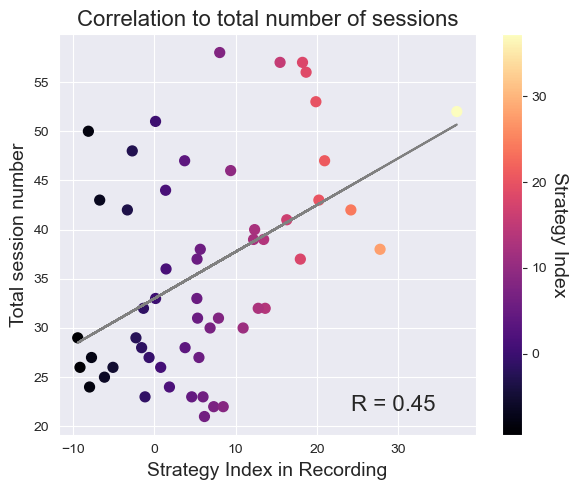

In [89]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.set_style('darkgrid')
r = np.corrcoef(session_df['session_number'], session_df['strategy_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=session_df.strategy_index, 
                     y=session_df.session_number, 
                     c=session_df.strategy_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 

# Calculate and plot regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(session_df.strategy_index, session_df.session_number)
line = slope * session_df.strategy_index + intercept
ax.plot(session_df.strategy_index, line, color='grey',label='Regression Line')



cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize = 14)


ax.set_xlabel('Strategy Index in Recording', fontsize = 14)
ax.set_ylabel('Total session number', fontsize = 14)
ax.set_title('Correlation to total number of sessions', fontsize = 16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()


----

#### Correlations with before hand-off # of sessions:

Here sessions that belong to the same animal will have the same # of sessions before hand-off. 

We get this number by finding the max session number during the `TRAINING_5_images_X_epilogue_5uL_reward` and plus 1.

In [74]:
# Get sorted session by average index (don't really need to; grabbed from another notebook): 
session_df['mouse_id'] = subset_sessions.mouse_id
mouse_avg = session_df.groupby('mouse_id')['strategy_index'].mean().sort_values()
mouse_avg_dict = mouse_avg.to_dict()
session_df['avg_strategy_index'] = session_df['mouse_id'].map(mouse_avg_dict)
session_df_sorted_by_avg = session_df.sort_values('avg_strategy_index')

# Get unique mouse IDs in the sorted order:
unique_mice = session_df_sorted_by_avg['mouse_id'].unique()

In [79]:
behavior_sessions.session_type.unique()

array(['HABITUATION_5_images_G_handoff_ready_5uL_reward',
       'TRAINING_1_gratings', 'TRAINING_2_gratings_flashed',
       'TRAINING_5_images_G_epilogue', 'TRAINING_3_images_G_10uL_reward',
       'TRAINING_4_images_G_training',
       'TRAINING_0_gratings_autorewards_15min',
       'HABITUATION_5_images_G_handoff_ready_3uL_reward',
       'TRAINING_5_images_G_handoff_ready_5uL_reward',
       'TRAINING_4_images_G_training_7uL_reward',
       'TRAINING_2_gratings_flashed_10uL_reward',
       'TRAINING_1_gratings_10uL_reward',
       'TRAINING_0_gratings_autorewards_15min_0uL_reward',
       'TRAINING_5_images_G_epilogue_5uL_reward',
       'EPHYS_1_images_G_3uL_reward',
       'TRAINING_5_images_G_handoff_lapsed_5uL_reward',
       'EPHYS_1_images_H_3uL_reward',
       'HABITUATION_5_images_H_handoff_ready_5uL_reward',
       'HABITUATION_5_images_H_handoff_ready_3uL_reward',
       'TRAINING_5_images_H_handoff_ready_5uL_reward',
       'TRAINING_3_images_H_10uL_reward',
       'TRA

In [82]:
min_session_numbers = []

for mouse_id in unique_mice:
    mouse_sessions = behavior_sessions[
        (behavior_sessions.mouse_id == mouse_id) & 
        (behavior_sessions.session_type.str.contains('handoff_ready') )
    ]
    # Check if there are any sessions for this mouse, if not, report
    if not mouse_sessions.empty:
        # Find the maximum session number during `epilogue_TRAINING_5` and append it to the list
        min_session_number = mouse_sessions.session_number.min()
        min_session_numbers.append(min_session_number)
    else:
        print("something's wrong!", mouse_id)
        continue

print(f"Minimum handoff ready session numbers:\n{min_session_numbers}")

Minimum handoff ready session numbers:
[15, 18, 13, 16, 17, 18, 11, 12, 12, 26, 15, 23, 14, 14, 10, 12, 23, 19, 17, 12, 21, 18, 16, 12, 19, 26, 16]


In [83]:
max_session_numbers = []

for mouse_id in unique_mice:
    mouse_sessions = behavior_sessions[
        (behavior_sessions.mouse_id == mouse_id) & 
        (behavior_sessions.session_type.str.contains('epilogue') )
    ]
    # Check if there are any sessions for this mouse, if not, report
    if not mouse_sessions.empty:
        # Find the maximum session number during `epilogue_TRAINING_5` and append it to the list
        max_session_number = mouse_sessions.session_number.max()
        max_session_numbers.append(max_session_number + 1)
    else:
        print("something's wrong!", mouse_id)
        continue

print(f"Maximum epilogue session (+1) numbers:\n{max_session_numbers}")

Maximum epilogue session (+1) numbers:
[15, 18, 13, 16, 17, 18, 11, 12, 12, 26, 15, 23, 14, 14, 10, 12, 23, 19, 17, 12, 21, 18, 16, 12, 19, 26, 16]


In [76]:
mouse_df = pd.DataFrame(data = np.array([unique_mice, mouse_avg.tolist(), max_session_numbers]).T, 
                        columns = ['mouse_id', 'avg_index', 'max_session_before_handoff'])

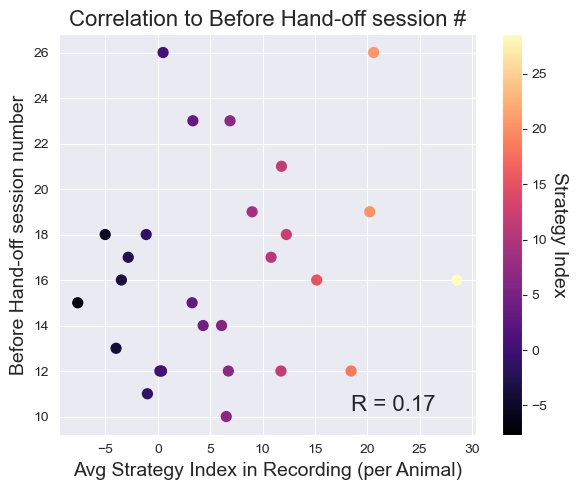

In [77]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.set_style('darkgrid')
r = np.corrcoef(mouse_df['max_session_before_handoff'], mouse_df['avg_index'])

# Scatter plot with points colored by strategy_index
scatter = ax.scatter(x=mouse_df.avg_index, 
                     y=mouse_df.max_session_before_handoff, 
                     c=mouse_df.avg_index, 
                     cmap='magma', 
                     s=50, 
                     alpha=1) 


cbar = plt.colorbar(scatter)
cbar.set_label('Strategy Index', rotation=270, labelpad=15, fontsize = 14)

ax.set_xlabel('Avg Strategy Index in Recording (per Animal)', fontsize = 14)
ax.set_ylabel('Before Hand-off session number', fontsize = 14)
ax.set_title('Correlation to Before Hand-off session #', fontsize = 16)

ax.text(0.70, 0.10, f'R = {r[0, 1]:.2f}', fontsize=16, 
        transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()
